
<img src="../../img/ods_stickers.jpg">

## <center> [mlcourse.ai](https://mlcourse.ai) – открытый курс OpenDataScience по машинному обучению 

    
Автор материала: Ольга Дайховская (@aiho в Slack ODS). Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала

# <center> Домашнее задание № 4 (демо).
## <center>  Прогнозирование популярности статей на TechMedia (Хабр) с помощью линейных моделей
    
**В задании Вам предлагается разобраться с тем, как работает TfidfVectorizer и DictVectorizer, затем обучить и настроить модель линейной регрессии Ridge на данных о публикациях на Хабрахабре. Пройдя все шаги, вы сможете **

**Описание соревнования**

Предскажите, как много звездочек наберет статья, зная только ее текст и время публикации

Необходимо предсказать популярность поста на Хабре по содержанию и времени публикации. Как известно, пользователи Хабра могут добавлять статьи к себе в избранное. Общее количество пользователей, которое это сделали отображается у статьи количеством звездочек. Будем считать, что число звездочек, поставленных статье, наиболее хорошо отражает ее популярность.

Более формально, в качестве метрики популярности статьи будем использовать долю статей за последний месяц, у которых количество звездочек меньше чем у текущей статьи. А точнее, доле числа звездочек можно поставить в соответствие квантили стандартного распределения, таким образом получаем числовую характеристику популярности статьи. Популярность статьи 0 означает, что статья получила ровно столько звездочек, сколько в среднем получают статьи. И соответственно чем больше звездочек получила статья по сравнению со средним, тем выше это число.

**Приступим:** импортируем необходимые библиотеки и скачаем данные

In [1]:
import numpy as np
import pandas as pd
import scipy
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
# при необходимости поменяйте путь к данным 
train_df = pd.read_csv('../../data/howpop_train.csv')
# with open('../../data/howpop_train.csv', 'r', encoding='utf-8', errors='replace') as f:
#     data = f.read()
test_df  = pd.read_csv('../../data/howpop_test.csv')

In [3]:
# test_df.head(1).T

In [4]:
train_df.head(1).T

,0
url,https://habrahabr.ru/post/18284/
domain,habrahabr.ru
post_id,18284
published,2008-01-01 18:19:00
author,@Tapac
flow,develop
polling,False
content_len,4305
title,Новогодний подарок блоггерам — WordPress 2.3.2
comments,0


In [5]:
train_df.shape, test_df.shape

((134137, 17), (3990, 9))

Убедимся, что данные отсортированы по признаку `published`

In [6]:
train_df['published']

0         2008-01-01 18:19:00
1         2008-01-01 18:30:00
2         2008-01-01 18:34:00
3         2008-01-02 01:32:00
4         2008-01-02 14:34:00
                 ...         
134132    2016-10-31 21:45:00
134133    2016-10-31 22:44:00
134134    2016-10-31 23:26:00
134135    2016-10-31 23:52:00
134136    2016-10-31 23:56:00
Name: published, Length: 134137, dtype: object

In [7]:
sort_published = train_df['published'].apply(lambda ts: pd.to_datetime(ts).value)

In [8]:
train_df['published'].apply(lambda ts: pd.to_datetime(ts))

0        2008-01-01 18:19:00
1        2008-01-01 18:30:00
2        2008-01-01 18:34:00
3        2008-01-02 01:32:00
4        2008-01-02 14:34:00
                 ...        
134132   2016-10-31 21:45:00
134133   2016-10-31 22:44:00
134134   2016-10-31 23:26:00
134135   2016-10-31 23:52:00
134136   2016-10-31 23:56:00
Name: published, Length: 134137, dtype: datetime64[ns]

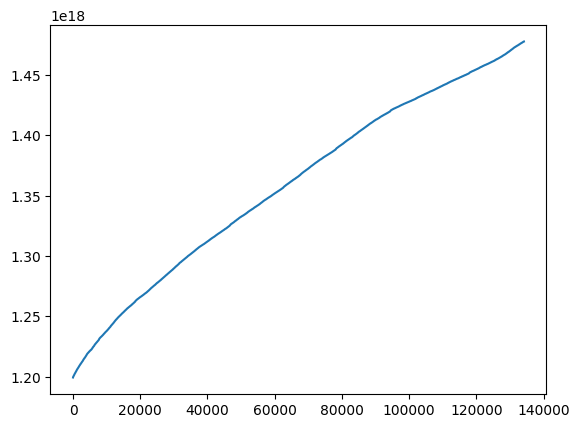

In [9]:
train_df['published'].apply(lambda ts: pd.to_datetime(ts).value).plot();

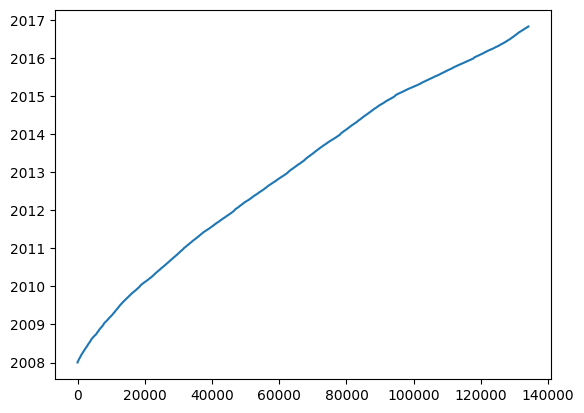

In [10]:
train_df['published'].apply(lambda ts: pd.to_datetime(ts)).plot();

**Чтобы ответить на вопросы 1 и 2, можно использовать [pandas.DataFrame.corr()](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.corr.html), [pandas.to_datetime()](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.to_datetime.html) и [pandas.Series.value_counts()](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.value_counts.html)**

ПРИВЁЛ TS К ПРАВИЛЬНОМУ ТИПУ ДАННЫХ

In [11]:
train_df["published_ts"] = pd.to_datetime(train_df["published"])

ПРИЗНАК DOMAIN ПРИВЕЛ К БИНАРНОМУ ТИПУ(ВСЕГО ДВА ВАРИАНТА 'habrahabr.ru', 'geektimes.ru')

In [12]:
train_df.domain.unique()

array(['habrahabr.ru', 'geektimes.ru'], dtype=object)

In [13]:
train_df["domain_new"] = train_df["domain"].apply(lambda boool: 1 if boool == 'habrahabr.ru' else 2)
# .apply(lambda ts: 1 if ts <= 11 else 0)

ПРИЗНАК flow ПРИВЕЛ К БИНАРНОМУ ТИПУ(ВСЕГО 6 ВАРИАНТ: ['develop', 'design', nan, 'misc', 'management', 'admin',
       'marketing'])

In [14]:
print(train_df.flow.unique())
print(train_df.flow.nunique())
train_df.flow.unique()

['develop' 'design' nan 'misc' 'management' 'admin' 'marketing']
6


array(['develop', 'design', nan, 'misc', 'management', 'admin',
       'marketing'], dtype=object)

In [15]:
from sklearn import preprocessing

In [16]:
flow_list = train_df.flow.unique().tolist()
flow_list

['develop', 'design', nan, 'misc', 'management', 'admin', 'marketing']

In [17]:
le = preprocessing.LabelEncoder()
le.fit(flow_list)
list(le.classes_)
le.transform(flow_list)
# le.inverse_transform([0, 0, 1, 2])

# train_df["flow_new"] = train_df["flow"].apply(lambda boool: 1 if boool == 'habrahabr.ru' else 2)

array([2, 1, 6, 5, 3, 0, 4])

In [18]:
train_df["flow_new"] = le.fit_transform(train_df["flow"])

In [19]:
train_df.flow_new.unique()

array([2, 1, 6, 5, 3, 0, 4])

ПРИЗНАК author ПРИВЕЛ К БИНАРНОМУ ТИПУ(ВСЕГО 22077 ВАРИАНТОВ)

In [20]:
train_df.author.nunique()

22077

In [21]:
train_df["author_new"] = le.fit_transform(train_df["author"])

In [22]:
train_df.author_new.nunique()

22078

ПРИЗНАК polling ПРИВЕЛ К БИНАРНОМУ ТИПУ(ВСЕГО 2 ВАРИАНТA)

In [23]:
train_df["polling_new"] = le.fit_transform(train_df["polling"])

In [24]:
train_df.polling_new.unique()

array([0, 1], dtype=int64)

ПРИЗНАК title ПРИВЕЛ К БИНАРНОМУ ТИПУ(ВСЕГО 22077 ВАРИАНТОВ)  
преобразовать к длине title??

In [25]:
train_df["title_new"] = le.fit_transform(train_df["title"])

In [26]:
train_df.title_new.nunique()

133628

In [27]:
train_df.shape

(134137, 23)

ПРИЗНАК url ПРИВЕЛ К БИНАРНОМУ ТИПУ(ВСЕГО 22077 ВАРИАНТОВ)  
удалить всё лишнее оставить только цифровое значение

In [28]:
train_df["url_new"] = train_df["url"].apply(lambda num: ''.join(char for char in num if char.isnumeric()))

In [29]:
train_df.url_new.nunique()

132985

In [30]:
train_df.sort_values(by="flow_new", ascending=True).head(4).T

,48845,105797,38583,13128
url,https://habrahabr.ru/post/138887/,https://habrahabr.ru/company/veeam/blog/261567/,https://habrahabr.ru/post/122669/,https://habrahabr.ru/post/64986/
domain,habrahabr.ru,habrahabr.ru,habrahabr.ru,habrahabr.ru
post_id,138887,261567,122669,64986
published,2012-02-27 00:56:00,2015-07-01 13:44:00,2011-06-28 09:59:00,2009-07-21 09:55:00
author,@giner,NaN,@mittel,@gribozavr
flow,admin,admin,admin,admin
polling,False,False,False,False
content_len,2164,4389,2986,5701
title,Роутер на базе PC или ноутбука за пару минут,Veeam Availability Suite v9: интеграция с сист...,"Опытные мелочи-8, или «Почтовая тройка на VBS»",Microsoft хочет внести свой код в ядро Linux —...
comments,10,2,10,169


<font color='red'>Вопрос 1.</font> Есть ли в 0.9 :)
- да
- нет
- не знаю

In [31]:
train_df.head(4).T

,0,1,2,3
url,https://habrahabr.ru/post/18284/,https://habrahabr.ru/post/18285/,https://habrahabr.ru/post/18286/,https://habrahabr.ru/post/18291/
domain,habrahabr.ru,habrahabr.ru,habrahabr.ru,habrahabr.ru
post_id,18284,18285,18286,18291
published,2008-01-01 18:19:00,2008-01-01 18:30:00,2008-01-01 18:34:00,2008-01-02 01:32:00
author,@Tapac,@DezmASter,@DezmASter,@Taoorus
flow,develop,design,design,design
polling,False,False,False,False
content_len,4305,7344,8431,5662
title,Новогодний подарок блоггерам — WordPress 2.3.2,"Сумасшедшие яйца, или сервис для отслеживания ...","Сумасшедшие яйца, или сервис для отслеживания ...","Сглаживание шрифтов, и субпиксельная отрисовка"
comments,0,1,47,102


In [32]:
train_df.columns

Index(['url', 'domain', 'post_id', 'published', 'author', 'flow', 'polling',
       'content_len', 'title', 'comments', 'favs', 'views', 'votes_plus',
       'votes_minus', 'views_lognorm', 'favs_lognorm', 'comments_lognorm',
       'published_ts', 'domain_new', 'flow_new', 'author_new', 'polling_new',
       'title_new', 'url_new'],
      dtype='object')

In [33]:
train_df.columns

Index(['url', 'domain', 'post_id', 'published', 'author', 'flow', 'polling',
       'content_len', 'title', 'comments', 'favs', 'views', 'votes_plus',
       'votes_minus', 'views_lognorm', 'favs_lognorm', 'comments_lognorm',
       'published_ts', 'domain_new', 'flow_new', 'author_new', 'polling_new',
       'title_new', 'url_new'],
      dtype='object')

In [34]:
tt = train_df
tt = tt.drop(['published', 'domain', 'flow', 'author', 'polling',
       'title', 'url'], axis=1)
tt.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134137 entries, 0 to 134136
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   post_id           134137 non-null  int64         
 1   content_len       134137 non-null  int64         
 2   comments          134137 non-null  int64         
 3   favs              134137 non-null  int64         
 4   views             134137 non-null  int64         
 5   votes_plus        133566 non-null  float64       
 6   votes_minus       133566 non-null  float64       
 7   views_lognorm     134137 non-null  float64       
 8   favs_lognorm      134137 non-null  float64       
 9   comments_lognorm  134137 non-null  float64       
 10  published_ts      134137 non-null  datetime64[ns]
 11  domain_new        134137 non-null  int64         
 12  flow_new          134137 non-null  int32         
 13  author_new        134137 non-null  int32         
 14  poll

In [35]:
train_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134137 entries, 0 to 134136
Data columns (total 24 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   url               134137 non-null  object        
 1   domain            134137 non-null  object        
 2   post_id           134137 non-null  int64         
 3   published         134137 non-null  object        
 4   author            97657 non-null   object        
 5   flow              97048 non-null   object        
 6   polling           134137 non-null  bool          
 7   content_len       134137 non-null  int64         
 8   title             134137 non-null  object        
 9   comments          134137 non-null  int64         
 10  favs              134137 non-null  int64         
 11  views             134137 non-null  int64         
 12  votes_plus        133566 non-null  float64       
 13  votes_minus       133566 non-null  float64       
 14  view

In [36]:
train_df.describe().T

,count,mean,min,25%,50%,75%,max,std
post_id,134137.0,181307.054265,18284.0,115565.0,182666.0,257401.0,314088.0,81766.350702
content_len,134137.0,7516.929699,1.0,2179.0,4949.0,9858.0,352471.0,8724.77164
comments,134137.0,39.625994,0.0,7.0,19.0,48.0,2266.0,62.398958
favs,134137.0,71.999866,0.0,8.0,27.0,78.0,8718.0,145.854135
views,134137.0,16631.013084,3.0,2100.0,7600.0,18700.0,1730000.0,31479.819691
votes_plus,133566.0,35.536888,0.0,11.0,22.0,45.0,1466.0,42.461073
votes_minus,133566.0,8.050035,0.0,2.0,5.0,10.0,445.0,11.398282
views_lognorm,134137.0,0.004849,-6.615254,-0.706552,-0.020934,0.682689,5.182821,1.002158
favs_lognorm,134137.0,0.003402,-4.137662,-0.69578,0.007022,0.708778,4.872866,1.002778
comments_lognorm,134137.0,-0.003675,-4.161967,-0.633775,0.072082,0.697072,3.900973,1.005259


In [37]:
train_df.describe()

,post_id,content_len,comments,favs,views,votes_plus,votes_minus,views_lognorm,favs_lognorm,comments_lognorm,published_ts,domain_new,flow_new,author_new,polling_new,title_new
count,134137.000000,134137.000000,134137.000000,134137.000000,1.341370e+05,133566.000000,133566.000000,134137.000000,134137.000000,134137.000000,134137,134137.000000,134137.000000,134137.000000,134137.000000,134137.000000
mean,181307.054265,7516.929699,39.625994,71.999866,1.663101e+04,35.536888,8.050035,0.004849,0.003402,-0.003675,2013-02-02 03:19:49.550981632,1.276501,3.569567,14176.420540,0.035225,66818.340480
min,18284.000000,1.000000,0.000000,0.000000,3.000000e+00,0.000000,0.000000,-6.615254,-4.137662,-4.161967,2008-01-01 18:19:00,1.000000,0.000000,0.000000,0.000000,0.000000
25%,115565.000000,2179.000000,7.000000,8.000000,2.100000e+03,11.000000,2.000000,-0.706552,-0.695780,-0.633775,2011-02-21 13:35:00,1.000000,2.000000,8515.000000,0.000000,33452.000000
50%,182666.000000,4949.000000,19.000000,27.000000,7.600000e+03,22.000000,5.000000,-0.020934,0.007022,0.072082,2013-04-16 14:44:00,1.000000,3.000000,15153.000000,0.000000,66790.000000
75%,257401.000000,9858.000000,48.000000,78.000000,1.870000e+04,45.000000,10.000000,0.682689,0.708778,0.697072,2015-04-10 22:01:00,2.000000,6.000000,22077.000000,0.000000,100208.000000
max,314088.000000,352471.000000,2266.000000,8718.000000,1.730000e+06,1466.000000,445.000000,5.182821,4.872866,3.900973,2016-10-31 23:56:00,2.000000,6.000000,22077.000000,1.000000,133627.000000
std,81766.350702,8724.771640,62.398958,145.854135,3.147982e+04,42.461073,11.398282,1.002158,1.002778,1.005259,NaN,0.447269,1.974609,6987.736259,0.184349,38560.910755


In [38]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134137 entries, 0 to 134136
Data columns (total 24 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   url               134137 non-null  object        
 1   domain            134137 non-null  object        
 2   post_id           134137 non-null  int64         
 3   published         134137 non-null  object        
 4   author            97657 non-null   object        
 5   flow              97048 non-null   object        
 6   polling           134137 non-null  bool          
 7   content_len       134137 non-null  int64         
 8   title             134137 non-null  object        
 9   comments          134137 non-null  int64         
 10  favs              134137 non-null  int64         
 11  views             134137 non-null  int64         
 12  votes_plus        133566 non-null  float64       
 13  votes_minus       133566 non-null  float64       
 14  view

In [39]:
tt.corr()

,post_id,content_len,comments,favs,views,votes_plus,votes_minus,views_lognorm,favs_lognorm,comments_lognorm,published_ts,domain_new,flow_new,author_new,polling_new,title_new,url_new
post_id,1.000000,0.241384,-0.147763,0.089313,0.132385,-0.187885,-0.235594,-0.010376,-0.005845,-0.001605,0.962187,0.022554,-0.000605,0.191468,0.081628,0.037945,0.019062
content_len,0.241384,1.000000,-0.023544,0.308194,0.204101,0.068779,-0.078686,0.246063,0.356481,0.073132,0.251379,-0.132051,-0.174966,0.051584,-0.003337,0.061831,-0.003094
comments,-0.147763,-0.023544,1.000000,0.164166,0.290035,0.613961,0.457638,0.349568,0.278942,0.662740,-0.154728,0.122273,0.064792,-0.118787,0.042605,0.026731,-0.010151
favs,0.089313,0.308194,0.164166,1.000000,0.634304,0.416241,0.062877,0.456097,0.587982,0.263239,0.096807,-0.130297,-0.195618,-0.047018,0.006882,0.039603,-0.005358
views,0.132385,0.204101,0.290035,0.634304,1.000000,0.396849,0.128654,0.585105,0.406782,0.326427,0.142676,-0.029769,-0.087709,-0.025160,0.025660,0.035061,-0.005990
votes_plus,-0.187885,0.068779,0.613961,0.416241,0.396849,1.000000,0.464168,0.414232,0.449712,0.525081,-0.206423,0.029435,-0.027418,-0.132076,-0.033505,0.042239,-0.012333
votes_minus,-0.235594,-0.078686,0.457638,0.062877,0.128654,0.464168,1.000000,0.146609,0.088226,0.355458,-0.242614,0.015405,0.024813,-0.084891,0.027116,0.041948,-0.008378
views_lognorm,-0.010376,0.246063,0.349568,0.456097,0.585105,0.414232,0.146609,1.000000,0.688811,0.546530,-0.009566,0.002413,-0.108777,-0.052199,-0.003523,0.057347,-0.019461
favs_lognorm,-0.005845,0.356481,0.278942,0.587982,0.406782,0.449712,0.088226,0.688811,1.000000,0.479476,-0.004355,0.000735,-0.173380,-0.148330,-0.036385,0.074702,-0.017476
comments_lognorm,-0.001605,0.073132,0.662740,0.263239,0.326427,0.525081,0.355458,0.546530,0.479476,1.000000,0.001754,0.003435,-0.086911,-0.127646,0.071417,0.043079,-0.014223


In [40]:
corr_matrix = tt.corr()
mask = (corr_matrix > 0.9) & (corr_matrix != 1)
corr_matrix[mask].stack().index.tolist()

[('post_id', 'published_ts'), ('published_ts', 'post_id')]

In [41]:
# corr_matrix = tt.corr()
# mask = ~(corr_matrix.index == corr_matrix.columns)
# high_corr_cols = corr_matrix.abs()[mask].stack().sort_values(ascending=False)[lambda x: x < 0.9].index.tolist()
# high_corr_cols
# high_corr_features = corr_matrix.abs() > 0.9
# corr_matrix.columns[high_corr_features.any(axis=0)]

In [42]:
tt.columns

Index(['post_id', 'content_len', 'comments', 'favs', 'views', 'votes_plus',
       'votes_minus', 'views_lognorm', 'favs_lognorm', 'comments_lognorm',
       'published_ts', 'domain_new', 'flow_new', 'author_new', 'polling_new',
       'title_new', 'url_new'],
      dtype='object')

<font color='red'>Вопрос 2.</font> В каком 
- 2014
- 2015
- 2016
- 2017

In [43]:
tt["YEAR"] = tt.published_ts.apply(lambda ts: ts.year)

In [44]:
tt.YEAR.value_counts()

YEAR
2015    23452
2016    16316
2014    16180
2012    15972
2013    15537
2011    15063
2010    13091
2009    10783
2008     7743
Name: count, dtype: int64

## Разбиение на train/valid
Используем только признаки 'author', 'flow', 'domain' и 'title'

In [45]:
features = ['author', 'flow', 'domain','title']
train_size = int(0.7 * train_df.shape[0])

In [46]:
len(train_df), train_size

(134137, 93895)

In [47]:
X, y = train_df.loc[:, features],  train_df['favs_lognorm'] #отделяем признаки от целевой переменной

X_test = test_df.loc[:, features]

In [48]:
X_train, X_valid = X.iloc[:train_size, :], X.iloc[train_size:,:]

y_train, y_valid = y.iloc[:train_size], y.iloc[train_size:]

**Инициализируйте TfidfVectorizer с параметрами min_df=3, max_df=0.3 и ngram_range=(1, 3).<br />
Примените метод fit_transform к X_train['title'] и метод transform к X_valid['title'] и X_test['title']**

In [49]:
vectorizer_title = TfidfVectorizer(min_df=3, max_df=0.3 , ngram_range=(1, 3))

X_train_title = vectorizer_title.fit_transform(X_train['title'])
X_valid_title =vectorizer_title.transform(X_valid['title'])
X_test_title = vectorizer_title.transform(X_test['title'])

In [50]:
vectorizer_title.vocabulary_

{'новогодний': 31497,
 'подарок': 36257,
 'блоггерам': 14241,
 'wordpress': 12172,
 'новогодний подарок': 31499,
 'сумасшедшие': 45476,
 'яйца': 50489,
 'или': 22661,
 'сервис': 42745,
 'для': 18811,
 'отслеживания': 34225,
 'посетителей': 37373,
 'или сервис': 22833,
 'сервис для': 42751,
 'для отслеживания': 19413,
 'или сервис для': 22834,
 'сервис для отслеживания': 42753,
 'сглаживание': 42460,
 'шрифтов': 49862,
 'отрисовка': 34214,
 'сглаживание шрифтов': 42461,
 'почему': 37632,
 'мне': 28231,
 'не': 30755,
 'нравится': 31925,
 'iphone': 5951,
 'почему мне': 37659,
 'мне не': 28233,
 'не нравится': 30851,
 'всеобщая': 16456,
 'доступность': 20285,
 'действии': 18272,
 'чем': 49165,
 'суть': 45504,
 'проекта': 39310,
 'ru': 9541,
 'search': 9842,
 'запускается': 21584,
 'понедельник': 37201,
 'mobile': 7315,
 'выбор': 16759,
 'способа': 44575,
 'связи': 42437,
 'обзор': 32095,
 'под': 36147,
 'windows': 11973,
 'под windows': 36185,
 'онлайн': 33063,
 'банкинг': 13661,
 'оформле

In [135]:
len(vectorizer_title.vocabulary_.keys())

50624

<font color='red'>Вопрос 3.</font> Какой 
- 43789
- 50624
- 93895
- 74378

<font color='red'>Вопрос 4.</font> Какой 
- 1
- 10
- 9065
- 15679

In [51]:
vectorizer_title.vocabulary_['python']

9065

**Инициализируйте TfidfVectorizer, указав analyzer='char'.<br />
Примените метод fit_transform к X_train['title'] и метод transform к X_valid['title'] и X_test['title']**

<font color='red'>Вопрос 5.</font> Какой 
- 218
- 510
- 125
- 981

In [68]:
vectorizer_title_ch = TfidfVectorizer(analyzer='char')
# vectorizer_title_ch = TfidfVectorizer(analyzer='char', min_df=3, max_df=0.3 , ngram_range=(1, 3))

X_train_title_ch = vectorizer_title_ch.fit_transform(X_train['title'])
X_valid_title_ch = vectorizer_title_ch.transform(X_valid['title'])
X_test_title_ch = vectorizer_title_ch.transform(X_test['title'])

# vectorizer_title = TfidfVectorizer(min_df=3, max_df=0.3 , ngram_range=(1, 3))

# X_train_title = vectorizer_title.fit_transform(X_train['title'])
# X_valid_title = vectorizer_title.transform(X_valid['title'])
# X_test_title = vectorizer_title.transform(X_test['title'])

In [69]:
# Здесь так же можно посмотреть словарь
# Заметьте насколько отличаются словари для TfidfVectorizer с analyzer='word' и analyzer='char'
vectorizer_title_ch.vocabulary_

{'н': 133,
 'о': 134,
 'в': 122,
 'г': 123,
 'д': 124,
 'и': 128,
 'й': 129,
 ' ': 0,
 'п': 135,
 'а': 120,
 'р': 136,
 'к': 130,
 'б': 121,
 'л': 131,
 'е': 125,
 'м': 132,
 '—': 170,
 'w': 61,
 'o': 53,
 'r': 56,
 'd': 42,
 'p': 54,
 'e': 43,
 's': 57,
 '2': 18,
 '.': 14,
 '3': 19,
 'с': 137,
 'у': 139,
 'ш': 144,
 'я': 151,
 'ц': 142,
 ',': 12,
 'т': 138,
 'ж': 126,
 'ф': 140,
 'ь': 148,
 'ч': 143,
 'i': 47,
 'h': 46,
 'n': 52,
 'm': 51,
 'b': 40,
 'l': 50,
 '0': 16,
 'щ': 145,
 'k': 49,
 'v': 60,
 'a': 39,
 'u': 59,
 ':': 26,
 'c': 41,
 'з': 127,
 'ы': 147,
 '«': 76,
 '»': 85,
 'х': 141,
 'j': 48,
 '?': 31,
 't': 58,
 '-': 13,
 '1': 17,
 '8': 24,
 '!': 1,
 '9': 25,
 '5': 21,
 '7': 23,
 'q': 55,
 'y': 63,
 'x': 62,
 'g': 45,
 'ю': 150,
 'ъ': 146,
 '4': 20,
 '=': 29,
 '(': 8,
 ')': 9,
 '+': 11,
 'f': 44,
 '…': 178,
 'э': 149,
 '6': 22,
 'z': 64,
 '/': 15,
 '$': 4,
 'ё': 152,
 "'": 7,
 '№': 187,
 '–': 169,
 '[': 33,
 ']': 35,
 '_': 37,
 '\xa0': 71,
 '*': 10,
 '%': 5,
 '{': 65,
 '}': 6

In [67]:
len(vectorizer_title_ch.vocabulary_)

32839

In [70]:
len(vectorizer_title_ch.vocabulary_)

218

## Работа с категориальными признаками

Для обработки категориальных признаков 'author', 'flow', 'domain' мы будем использовать DictVectorizer из sklearn.

In [71]:
feats = ['author', 'flow', 'domain']
X_train[feats][:5]

,author,flow,domain
0,@Tapac,develop,habrahabr.ru
1,@DezmASter,design,habrahabr.ru
2,@DezmASter,design,habrahabr.ru
3,@Taoorus,design,habrahabr.ru
4,@dennydo,NaN,geektimes.ru


Рассмотрим как он работает на примере первых пяти строк

In [72]:
# сначала заполняем пропуски прочерком
X_train[feats][:5].fillna('-')

,author,flow,domain
0,@Tapac,develop,habrahabr.ru
1,@DezmASter,design,habrahabr.ru
2,@DezmASter,design,habrahabr.ru
3,@Taoorus,design,habrahabr.ru
4,@dennydo,-,geektimes.ru


In [73]:
# Преобразуем датафрейм в словарь, где ключами являются индексы объектов (именно для этого мы транспонировали датафрейм),
# а значениями являются словари в виде 'название_колонки':'значение'
X_train[feats][:5].fillna('-').T.to_dict()

{0: {'author': '@Tapac', 'flow': 'develop', 'domain': 'habrahabr.ru'},
 1: {'author': '@DezmASter', 'flow': 'design', 'domain': 'habrahabr.ru'},
 2: {'author': '@DezmASter', 'flow': 'design', 'domain': 'habrahabr.ru'},
 3: {'author': '@Taoorus', 'flow': 'design', 'domain': 'habrahabr.ru'},
 4: {'author': '@dennydo', 'flow': '-', 'domain': 'geektimes.ru'}}

In [75]:
# В DictVectorizer нам нужно будет передать список словарей для каждого объекта в виде 'название_колонки':'значение',
# поэтому используем .values()
X_train[feats][:5].fillna('-').T.to_dict().values()

dict_values([{'author': '@Tapac', 'flow': 'develop', 'domain': 'habrahabr.ru'}, {'author': '@DezmASter', 'flow': 'design', 'domain': 'habrahabr.ru'}, {'author': '@DezmASter', 'flow': 'design', 'domain': 'habrahabr.ru'}, {'author': '@Taoorus', 'flow': 'design', 'domain': 'habrahabr.ru'}, {'author': '@dennydo', 'flow': '-', 'domain': 'geektimes.ru'}])

In [76]:
# В итоге получается разреженная матрица
dict_vect = DictVectorizer()
dict_vect_matrix = dict_vect.fit_transform(X_train[feats][:5].fillna('-').T.to_dict().values())
dict_vect_matrix

<5x9 sparse matrix of type '<class 'numpy.float64'>'
	with 15 stored elements in Compressed Sparse Row format>

In [86]:
X_train[feats][:5].fillna('-').T.to_dict()

{0: {'author': '@Tapac', 'flow': 'develop', 'domain': 'habrahabr.ru'},
 1: {'author': '@DezmASter', 'flow': 'design', 'domain': 'habrahabr.ru'},
 2: {'author': '@DezmASter', 'flow': 'design', 'domain': 'habrahabr.ru'},
 3: {'author': '@Taoorus', 'flow': 'design', 'domain': 'habrahabr.ru'},
 4: {'author': '@dennydo', 'flow': '-', 'domain': 'geektimes.ru'}}

In [77]:
# Но можно преобразовать ее в numpy array с помощью .toarray()
dict_vect_matrix.toarray()

array([[0., 0., 1., 0., 0., 1., 0., 0., 1.],
       [1., 0., 0., 0., 0., 1., 0., 1., 0.],
       [1., 0., 0., 0., 0., 1., 0., 1., 0.],
       [0., 1., 0., 0., 0., 1., 0., 1., 0.],
       [0., 0., 0., 1., 1., 0., 1., 0., 0.]])

In [85]:
# В получившейся матрице 5 строк (по числу объектов) и 9 столбцов
# Далее разберемся почему колонок именно 9
dict_vect_matrix.shape

(5, 9)

Посмотрим сколько уникальных значений в каждой колонке.<br />
Суммарно их 9 - столько же, сколько и колонок. Это объясняется тем, что для категориальных признаков со строковыми значениями DictVectorizer делает кодирование бинарными признаками - каждому уникальному значению признака соответствует один новый бинарный признак, который равен 1 только в том случае, если в исходной матрице этот признак принимает значение, которому соответствует эта колонка новой матрицы.

In [83]:
for col in feats:
    print(col,len(X_train[col][:5].fillna('-').unique()))

author 4
flow 3
domain 2


In [95]:
X_train[feats][:5].fillna('-').T.to_dict()

{0: {'author': '@Tapac', 'flow': 'develop', 'domain': 'habrahabr.ru'},
 1: {'author': '@DezmASter', 'flow': 'design', 'domain': 'habrahabr.ru'},
 2: {'author': '@DezmASter', 'flow': 'design', 'domain': 'habrahabr.ru'},
 3: {'author': '@Taoorus', 'flow': 'design', 'domain': 'habrahabr.ru'},
 4: {'author': '@dennydo', 'flow': '-', 'domain': 'geektimes.ru'}}

In [93]:
dict_vect_matrix.toarray()

array([[0., 0., 1., 0., 0., 1., 0., 0., 1.],
       [1., 0., 0., 0., 0., 1., 0., 1., 0.],
       [1., 0., 0., 0., 0., 1., 0., 1., 0.],
       [0., 1., 0., 0., 0., 1., 0., 1., 0.],
       [0., 0., 0., 1., 1., 0., 1., 0., 0.]])

Также можно посмотреть что означает каждая колонка полученной матрицы  
dict_vect.feature_names_

In [84]:
# например, самая первая колонка называется 'author=@DezmASter' - то есть принимает значение 1 только если автор @DezmASter
dict_vect.feature_names_
# 9 строк

['author=@DezmASter',
 'author=@Taoorus',
 'author=@Tapac',
 'author=@dennydo',
 'domain=geektimes.ru',
 'domain=habrahabr.ru',
 'flow=-',
 'flow=design',
 'flow=develop']

**Инициализируйте DictVectorizer с параметрами по умолчанию.<br />
Примените метод fit_transform к X_train[feats] и метод transform к X_valid[feats] и X_test[feats]**

In [97]:
# # В итоге получается разреженная матрица
# dict_vect = DictVectorizer()
# dict_vect_matrix = dict_vect.fit_transform(X_train[feats][:5].fillna('-').T.to_dict().values())
# dict_vect_matrix

vectorizer_feats = DictVectorizer()

X_train_feats = vectorizer_feats.fit_transform(X_train[feats].fillna('-').T.to_dict().values())
X_valid_feats = vectorizer_feats.transform(X_valid[feats].fillna('-').T.to_dict().values())
X_test_feats = vectorizer_feats.transform(X_test[feats].fillna('-').T.to_dict().values())

In [98]:
X_train_feats.shape

(93895, 17869)

Соединим все полученные матрицы при помощи scipy.sparse.hstack()

In [99]:
X_train_new = scipy.sparse.hstack([X_train_title, X_train_feats, X_train_title_ch])
X_valid_new = scipy.sparse.hstack([X_valid_title, X_valid_feats, X_valid_title_ch])
X_test_new =  scipy.sparse.hstack([X_test_title, X_test_feats, X_test_title_ch])

## Обучение модели

Далее будем использовать Ridge, линейную модель с l2-регуляризацией.
[Документация](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html)

Основной параметр Ridge - **alpha, коэффициент регуляризации**. Регуляризация используется для улучшения обобщающей способности модели - прибавляя к функционалу потерь сумму квадратов весов, умноженную на коэффициент регуляризации (та самая alpha), мы штрафуем модель за слишком большие значения весов и не позволяем ей переобучаться. Чем больше этот коээфициент, тем сильнее эффект.

**Обучите две модели на X_train_new, y_train, задав в первой alpha=0.1 и random_state = 1, а во второй alpha=1.0 и random_state = 1**

**Рассчитайте среднеквадратичную ошибку каждой модели (mean_squared_error). Сравните значения ошибки на обучающей и тестовой выборках и ответьте на вопросы.**

<font color='red'>Вопрос 6.</font> 

In [102]:
%%time
model1 = Ridge(alpha=0.1, random_state=1)
model1.fit(X_train_new, y_train)

CPU times: total: 13.9 s
Wall time: 3.2 s


Ridge(alpha=0.1, random_state=1)

In [104]:
train_preds1 = model1.predict(X_train_new)
valid_preds1 = model1.predict(X_valid_new)

print('Ошибка на трейне',mean_squared_error(y_train, train_preds1))
print('Ошибка на тесте',mean_squared_error(y_valid, valid_preds1))

Ошибка на трейне 0.18350837777212417
Ошибка на тесте 0.9058695108884282


In [103]:
%%time
model2 = Ridge(alpha=1, random_state=1)
model2.fit(X_train_new, y_train)

CPU times: total: 5.03 s
Wall time: 1.23 s


Ridge(alpha=1, random_state=1)

In [105]:
train_preds2 = model2.predict(X_train_new)
valid_preds2 = model2.predict(X_valid_new)

print('Ошибка на трейне',mean_squared_error(y_train, train_preds2))
print('Ошибка на тесте',mean_squared_error(y_valid, valid_preds2))

Ошибка на трейне 0.28625115527348555
Ошибка на тесте 0.701237266950392


## Baseline

**Теперь попытаемся получить бейзлайн для соревования - используйте Ridge с параметрами по умолчанию и обучите модель на всех данных - соедините X_train_new X_valid_new (используйте scipy.sparse.vstack()), а целевой переменной будет y.**

In [107]:
%%time
model = Ridge()
model.fit(X_train_new, y_train)
model.fit(X_valid_new, y_valid)
test_preds = model.predict(X_test_new)
test_preds
# .fit(X_train_new, y_train)

CPU times: total: 8.33 s
Wall time: 2.04 s


array([ 0.42183659, -0.69159275,  1.21390718, ...,  0.83629348,
        0.18382391,  0.54278334])

In [108]:
sample_submission = pd.read_csv('../../data/habr_sample_submission.csv', 
                                index_col='url')

In [109]:
sample_submission.head()

,favs_lognorm
url,
https://habrahabr.ru/post/314080/,0.323588
https://habrahabr.ru/company/plesk/blog/313732/,0.560105
https://habrahabr.ru/company/etagi/blog/314000/,0.667039
https://habrahabr.ru/company/knopka/blog/314030/,0.149563
https://geektimes.ru/company/audiomania/blog/282058/,0.670754


In [110]:
ridge_submission = sample_submission.copy()
ridge_submission['favs_lognorm'] = test_preds
# это будет бейзлайн "Простое решение"
ridge_submission.to_csv('ridge_baseline.csv') 

Константное предсказание
1.01396


145
Ivan Shamanaev
1.35645
1
7y  
что здесь произхсодит?

моего вообще нету(((